<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fgeneration/applications/generation/image_captioning/Image%20Captioning%20with%20Beam%20Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Flickr8k Dataset

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ravirajag","key":"3ebe1017281784a1ca4b048c597b0c87"}'}

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d adityajn105/flickr8k

 99% 1.02G/1.04G [00:10<00:00, 129MB/s]
100% 1.04G/1.04G [00:10<00:00, 109MB/s]


In [6]:
!unzip -qq flickr8k.zip -d flickr8k

In [7]:
!ls flickr8k

captions.txt  Images


### Imports

In [8]:
import os
import time
import nltk
import pickle
import random

import numpy as np

from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data

from torch.nn.utils.rnn import pack_padded_sequence
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform

In [9]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Captions

In [11]:
captions = dict()

with open('flickr8k/captions.txt', 'r') as f:
    lines= f.readlines()
    for idx, line in enumerate(lines[1:]):
        index=line.index(',')
        img_id = line[:index].split('.')[0]
        img_caption = line[index+1:].strip()
        captions[idx] = {"image_id": img_id, "caption": img_caption}


In [12]:
len(captions)

40455

In [191]:
captions[1200]

{'caption': 'a boy in white plays baseball .',
 'image_id': '1285067106_2adc307240'}

### Vocabulary

In [14]:
class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [15]:
def build_vocab(captions_dict, threshold):
    """Build a simple vocabulary wrapper."""
    counter = Counter()
    for i, id in enumerate(captions_dict):
        caption = captions_dict[id]["caption"]
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i+1) % 5000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(captions_dict)))

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

In [16]:
vocab = build_vocab(captions, threshold=5)
vocab_path = 'vocab.pkl'
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)
print("Total vocabulary size: {}".format(len(vocab)))
print("Saved the vocabulary wrapper to '{}'".format(vocab_path))

[5000/40455] Tokenized the captions.
[10000/40455] Tokenized the captions.
[15000/40455] Tokenized the captions.
[20000/40455] Tokenized the captions.
[25000/40455] Tokenized the captions.
[30000/40455] Tokenized the captions.
[35000/40455] Tokenized the captions.
[40000/40455] Tokenized the captions.
Total vocabulary size: 3006
Saved the vocabulary wrapper to 'vocab.pkl'


### Image Processing

In [17]:
def resize_image(image, size):
    return image.resize(size, Image.ANTIALIAS)

def resize_images(image_dir, output_dir, size):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    images = os.listdir(image_dir)
    num_images = len(images)
    for i, image in enumerate(images):
        with open(os.path.join(image_dir, image), 'r+b') as f:
            with Image.open(f) as img:
                img = resize_image(img, size)
                img.save(os.path.join(output_dir, image), img.format)
        if (i+1) % 1000 == 0:
            print (f"[{i+1}/{num_images}] Resized the images and saved into '{output_dir}'.")
    

In [18]:
image_dir = "flickr8k/Images"
processed_image_dir = "processed_images"
size = [256, 256]

In [19]:
resize_images(image_dir, processed_image_dir, size)

[1000/8091] Resized the images and saved into 'processed_images'.
[2000/8091] Resized the images and saved into 'processed_images'.
[3000/8091] Resized the images and saved into 'processed_images'.
[4000/8091] Resized the images and saved into 'processed_images'.
[5000/8091] Resized the images and saved into 'processed_images'.
[6000/8091] Resized the images and saved into 'processed_images'.
[7000/8091] Resized the images and saved into 'processed_images'.
[8000/8091] Resized the images and saved into 'processed_images'.


### Caption Dataset

In [20]:
class CaptionDataset(data.Dataset):
    def __init__(self, image_dir, annotations, vocab, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations
        self.vocab = vocab
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, item):
        img_id = self.annotations[item]["image_id"]
        caption = self.annotations[item]["caption"]

        image = Image.open(os.path.join(self.image_dir, img_id+'.jpg')).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        
        caption = torch.Tensor(caption)
        return image, caption

In [21]:
# Image preprocessing, normalization for the pretrained resnet
crop_size = 224
transform = transforms.Compose([ 
    transforms.RandomCrop(crop_size),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                            (0.229, 0.224, 0.225))])

In [22]:
train_captions, valid_captions = train_test_split(captions, test_size=0.1, random_state=42)

In [32]:
len(train_captions), len(valid_captions)

(36409, 4046)

In [24]:
image_dir = "processed_images"

train_caption_dataset = CaptionDataset(image_dir, train_captions, vocab, transform)
valid_caption_dataset = CaptionDataset(image_dir, valid_captions, vocab, transform)

### DataLoader

In [25]:
def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

In [26]:
train_data_loader = torch.utils.data.DataLoader(
    dataset=train_caption_dataset, 
    batch_size=32,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn)

valid_data_loader = torch.utils.data.DataLoader(
    dataset=valid_caption_dataset, 
    batch_size=16,
    shuffle=False,
    collate_fn=collate_fn)

In [33]:
sample = next(iter(train_data_loader))
sample[0].shape, sample[1].shape, len(sample[2])

(torch.Size([32, 3, 224, 224]), torch.Size([32, 20]), 32)

### Encoder

In [34]:
class Encoder(nn.Module):
    def __init__(self, encoded_image_size=14):
        super().__init__()

        resnet = models.resnet152(pretrained=True)

        # remove the linear and pooling layers
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

    
    def forward(self, images):
        # images => [batch_size, 3, 224, 224]
        with torch.no_grad():
            features = self.resnet(images)
            # features => [batch_size, 2048, 7, 7]
        
        pooled = self.adaptive_pool(features)
        # pooled => [batch_size, 2048, encoded_img_size, encoded_img_size]
        #        => [batch_size, 2048, 14, 14]

        out = pooled.permute(0, 2, 3, 1)
        # out => [batch_size, 14, 14, 2048]

        return out

### Attention


In [35]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super().__init__()

        self.encoder_attn = nn.Linear(encoder_dim, attention_dim)
        self.decoder_attn = nn.Linear(decoder_dim, attention_dim)
        self.full_attn = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, encoder_out, decoder_hidden):
        enc_attn = self.encoder_attn(encoder_out)
        # enc_attn => [batch_size, num_pixels, attention_dim]

        dec_attn = self.decoder_attn(decoder_hidden)
        # dec_attn => [batch_size, attention_dim]

        attn = self.full_attn(self.relu(enc_attn + dec_attn.unsqueeze(1)))
        # attn => [batch_size, num_pixels, 1]

        attn = attn.squeeze(2)
        # attn => [batch_size, num_pixels]

        alpha = self.softmax(attn)
        # alpha => [batch_size, num_pixels]

        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        # attention_weighted_encoding => [batch_size, encoder_dim]

        return attention_weighted_encoding, alpha

### Decoder

In [36]:
class Decoder(nn.Module):
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        super().__init__()

        self.vocab_size = vocab_size

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.LSTM(embed_dim, decoder_dim, batch_first=True)

        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(embed_dim + encoder_dim + decoder_dim, vocab_size)
        self.init_weights()

    def init_weights(self):
        # initialize the parameters of the model with uniform distribution
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.out.bias.data.fill_(0)
        self.out.weight.data.uniform_(-0.1, 0.1)

    def forward(self, trg, hidden, cell, encoder_out):
        # trg => [batch_size, 1]

        embedded = self.embedding(trg)
        # embedded => [batch_size, 1, emb_dim]

        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # output => [batch_size, 1, hid_dim]
        # hidden, cell => [num_layers, batch_size, hid_dim]

        awe, alpha = self.attention(encoder_out, output[:, 0, :])
        # awe => [batch_size, encoder_dim]
        # alpha => [batch_size, num_pixels]

        combined = torch.cat([embedded.squeeze(1), awe, output[:, 0, :]], dim=1)
        # combined => [batch_size, emb_dim + encoder_dim + decoder_dim]
        
        logits = self.out(self.dropout(combined))
        # logits => [batch_size, vocab_size]

        return logits, hidden, cell, alpha

### Model

In [50]:
class ImgCapModel(nn.Module):
    def __init__(self, encoder, decoder, encoder_dim, decoder_dim, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
    
    def init_hidden_state(self, encoder_out):
        # encoder_out => [batch_size, num_pixels, encoder_dim]

        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c
    
    def forward(self, images, captions, lengths, teacher_forcing_ratio=0.5):
        # images => [batch_size, 3, 224, 224]
        # captions => [batch_size, max_seq_len]
        # lengths => [batch_size]

        encoded_images = self.encoder(images)
        # encoded_images => [batch_size, 14, 14, 2048]

        batch_size = encoded_images.size(0)
        encoder_dim = encoded_images.size(-1)
        encoder_out = encoded_images.view(batch_size, -1, encoder_dim)

        num_pixels = encoder_out.size(1)

        hidden, cell = self.init_hidden_state(encoder_out)
        # hidden, cell => [batch_size, decoder_dim]

        hidden = hidden.unsqueeze(0)
        cell = cell.unsqueeze(0)
        # hidden, cell => [1, batch_size, decoder_dim]

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = [length - 1 for length in lengths]

        trg_len = captions.shape[1]
        batch_size = images.shape[0]
        output_dim = self.decoder.vocab_size
        outputs = torch.zeros(batch_size, trg_len, output_dim).to(self.device)

        dec_inp = captions[:, 0]
        for t in range(max(decode_lengths)):
            # calculate batch_size at each time step, so that only that part
            # will be used to train the model. 
            batch_size_t = sum([l > t for l in decode_lengths])

            output, hidden, cell, alpha = self.decoder(
                dec_inp[:batch_size_t].unsqueeze(1),
                hidden[:, :batch_size_t, :],
                cell[:, :batch_size_t, :],
                encoder_out[:batch_size_t])

            # save the output
            outputs[:batch_size_t, t, :] = output

            # to do teacher force or not
            teacher_force = random.random() < teacher_forcing_ratio

            # get the top prediction
            top1 = output.argmax(1)

            # next time step decoder inputs
            dec_inp = captions[:batch_size_t, t] if teacher_force else top1

        return outputs 

### Model

In [51]:
embed_dim = 256
encoder_dim = 2048
decoder_dim = 512
attention_dim = 512

Model Instantiation

In [112]:
encoder = Encoder().to(device)
decoder = Decoder(attention_dim, embed_dim, decoder_dim, len(vocab)).to(device)
model = ImgCapModel(encoder, decoder, encoder_dim, decoder_dim, device).to(device)

### Loss & Optimizer

In [113]:
criterion = nn.CrossEntropyLoss()

In [114]:
# considering only the adaptive_pool parameters in the encoder
# resnet model is not updated during the training
params = list(model.decoder.parameters()) + list(model.encoder.adaptive_pool.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)

### Configurations

In [115]:
num_epochs = 4
log_step = 100
model_path = "models"

In [116]:
# make the model directory if it is not present means
# model will be saved here
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [117]:
# empty any unused cache
torch.cuda.empty_cache()

### Train Method

In [118]:
def train(data_loader, model, device):
    epoch_loss = 0
    total_steps = len(data_loader)

    # keep the model in training mode
    model.train()
    
    for i, (images, captions, lengths) in enumerate(data_loader):
        # zero the gradients
        optimizer.zero_grad()

        images = images.to(device)
        captions = captions.to(device)

        # forward pass
        output = model(images, captions, lengths)
        
        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = [length - 1 for length in lengths]

        # packing the outputs and captions, so that loss will be cal. only on the valid data
        # and not on padded captions
        outputs = pack_padded_sequence(output, decode_lengths, batch_first=True)[0]
        targets = pack_padded_sequence(captions, decode_lengths, batch_first=True)[0]

        # loss
        loss = criterion(outputs, targets)
        epoch_loss += loss.item()
        
        # backward pass
        loss.backward()

        # clip the gradients
        torch.nn.utils.clip_grad_norm_(params, 5.)

        # update parameters
        optimizer.step()

        # Print log info
        if i % log_step == 0:
            print(f'Step [{i}/{total_steps}], Loss: {loss.item():.4f}, Perplexity: {np.exp(loss.item()):5.4f}') 
            
    return epoch_loss / total_steps

### Validation Method

In [119]:
def evaluate(data_loader, model, device):
    epoch_loss = 0
    total_steps = len(data_loader)

    # keep the model eval mode
    model.eval()

    # gradients are not required in case of evaluation
    with torch.no_grad():
        for i, (images, captions, lengths) in enumerate(data_loader):
            images = images.to(device)
            captions = captions.to(device)

            # forward pass
            output = model(images, captions, lengths)

            # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
            # So, decoding lengths are actual lengths - 1
            decode_lengths = [length - 1 for length in lengths]

            # packing the outputs and captions, so that loss will be cal. only on the valid data
            # and not on padded captions
            outputs = pack_padded_sequence(output, decode_lengths, batch_first=True)[0]
            targets = pack_padded_sequence(captions, decode_lengths, batch_first=True)[0]

            # loss
            loss = criterion(outputs, targets)
            epoch_loss += loss.item()

            # Print log info
            if i % log_step == 0:
                print(f'Step [{i}/{total_steps}], Loss: {loss.item():.4f}, Perplexity: {np.exp(loss.item()):5.4f}') 
                
    return epoch_loss / total_steps

In [120]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Training

In [121]:
best_valid_loss = float('inf')
for epoch in range(num_epochs):
    
    start_time = time.time()
    train_loss = train(train_data_loader, model, device)
    val_loss = evaluate(valid_data_loader, model, device)
    end_time = time.time()

    elapsed_mins, elapsed_secs = epoch_time(start_time, end_time)

    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), os.path.join(model_path, 'model-{}.ckpt'.format(epoch+1)))

    print(f"Epoch: {epoch+1:02} | Time: {elapsed_mins}m {elapsed_secs}s")
    print(f"\t Train Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):5.4f} | Valid Loss: {val_loss:.3f} | Valid PPL: {np.exp(val_loss):5.4f}")

Step [0/1138], Loss: 10.5413, Perplexity: 37847.1976
Step [100/1138], Loss: 4.9382, Perplexity: 139.5145
Step [200/1138], Loss: 4.7156, Perplexity: 111.6731
Step [300/1138], Loss: 4.7794, Perplexity: 119.0280
Step [400/1138], Loss: 4.1461, Perplexity: 63.1890
Step [500/1138], Loss: 4.2259, Perplexity: 68.4335
Step [600/1138], Loss: 3.8187, Perplexity: 45.5449
Step [700/1138], Loss: 3.7159, Perplexity: 41.0939
Step [800/1138], Loss: 3.9793, Perplexity: 53.4791
Step [900/1138], Loss: 4.1887, Perplexity: 65.9340
Step [1000/1138], Loss: 3.9514, Perplexity: 52.0063
Step [1100/1138], Loss: 3.6370, Perplexity: 37.9778
Step [0/253], Loss: 3.8151, Perplexity: 45.3820
Step [100/253], Loss: 3.6176, Perplexity: 37.2486
Step [200/253], Loss: 3.4599, Perplexity: 31.8146
Epoch: 01 | Time: 20m 18s
	 Train Loss: 4.304 | Train PPL: 73.9837 | Valid Loss: 3.606 | Valid PPL: 36.8182
Step [0/1138], Loss: 3.4833, Perplexity: 32.5655
Step [100/1138], Loss: 3.8933, Perplexity: 49.0745
Step [200/1138], Loss: 3.

In [122]:
!ls -lah models

total 1.1G
drwxr-xr-x 2 root root 4.0K Jul 14 17:57 .
drwxr-xr-x 1 root root 4.0K Jul 14 15:25 ..
-rw-r--r-- 1 root root 277M Jul 14 16:56 model-1.ckpt
-rw-r--r-- 1 root root 277M Jul 14 17:16 model-2.ckpt
-rw-r--r-- 1 root root 277M Jul 14 17:37 model-3.ckpt
-rw-r--r-- 1 root root 277M Jul 14 17:57 model-4.ckpt


### Inference

In [123]:
embed_dim = 256
encoder_dim = 2048
decoder_dim = 512
attention_dim = 512

In [124]:
vocab_path = "vocab.pkl"
# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

In [125]:
encoder = Encoder().to(device)
decoder = Decoder(attention_dim, embed_dim, decoder_dim, len(vocab)).to(device)
model = ImgCapModel(encoder, decoder, encoder_dim, decoder_dim, device).to(device)

Load the pre-trained checkpoint

In [126]:
model_path = "models/model-4.ckpt"

# Load the trained model parameters
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [127]:
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

In [128]:
inf_transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])

In [178]:
def greedy_generated_caption(image_path, model, device, max_seq_len=20):
    vocab_size = len(vocab)

    # Prepare an image
    image = load_image(image_path, inf_transform)

    image_tensor = image.to(device)
    
    model.eval()

    with torch.no_grad():
        encoded_image = model.encoder(image_tensor)
        # encoded_image => [1, 14, 14, 2048]

        batch_size = encoded_image.size(0)
        encoder_dim = encoded_image.size(-1)
        encoder_out = encoded_image.view(batch_size, -1, encoder_dim)
        # encoder_out => [1, 196, 2048]

        num_pixels = encoder_out.size(1)

        hidden, cell = model.init_hidden_state(encoder_out)
        # hidden, cell => [1, decoder_dim]
        hidden = hidden.unsqueeze(0)
        cell = cell.unsqueeze(0)
        # hidden, cell => [1, 1, decoder_dim]

        trg_len = max_seq_len
        batch_size = 1
        output_dim = model.decoder.vocab_size
        outputs = torch.zeros(batch_size, trg_len, output_dim).to(device)
        alphas = torch.zeros(batch_size, trg_len, num_pixels).to(device)

        dec_inp = torch.LongTensor([vocab.word2idx['<start>']]).to(device)
        sampled_ids = []
        for t in range(1, trg_len):
            output, hidden, cell, alpha = model.decoder(dec_inp.unsqueeze(1), hidden, cell, encoder_out)

            outputs[:, t, :] = output
            alphas[:, t, :] = alpha
            # get the top prediction
            top1 = output.argmax(1)

            dec_inp = top1
            sampled_ids.append(top1.item())

    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids[1:]:
        word = vocab.idx2word[word_id]
        if word == '<end>':
            break
        sampled_caption.append(word)

    sentence = ' '.join(sampled_caption)
    # Print out the image and the generated caption
    image = Image.open(image_path)
    plt.imshow(np.asarray(image))
    print("Greedy generated caption")
    print("-"*50)
    print(sentence)

In [179]:
def beam_generated_captions(image_path, model, device, max_len=20, beam_size=5, length_norm_coefficient=0.6):
    with torch.no_grad():
        model.eval()

        k = beam_size

        # vocab size
        vocab_size = model.decoder.vocab_size

        # Prepare an image
        image = load_image(image_path, inf_transform)

        image_tensor = image.to(device)

        encoded_image = model.encoder(image_tensor)
        # encoded_image => [1, 14, 14, 2048]

        batch_size = encoded_image.size(0)
        encoder_dim = encoded_image.size(-1)
        encoder_out = encoded_image.view(batch_size, -1, encoder_dim)
        # encoder_out => [1, 196, 2048]

        num_pixels = encoder_out.shape[1]   # 196

        # We'll treat the problem as having a batch size of k
        encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

        # Tensor to store top k previous words at each step; now they're just <start>
        k_prev_words = torch.LongTensor([[vocab.word2idx['<start>']]] * k).to(device)  # (k, 1)

        # Tensor to store top k sequences; now they're just <start>
        seqs = k_prev_words  # (k, 1)

        # Tensor to store top k sequences' scores; now they're just 0
        top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

        # Lists to store completed sequences, their alphas and scores
        complete_seqs = list()
        complete_seqs_scores = list()

        # Start decoding
        step = 1
        hidden, cell = model.init_hidden_state(encoder_out)

        hidden = hidden.unsqueeze(0)
        cell = cell.unsqueeze(0)

        # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
        while True:

            logits, hidden, cell, _ = model.decoder(k_prev_words, hidden, cell, encoder_out)
            
            # logits => [s, vocab_size]
            scores = F.log_softmax(logits, dim=1)

            # Add
            scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

            # For the first step, all k points will have the same scores (since same k previous words, h, c)
            if step == 1:
                top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
            else:
                # Unroll and find top scores, and their unrolled indices
                top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

            # Convert unrolled indices to actual indices of scores
            prev_word_inds = top_k_words / vocab_size  # (s)
            next_word_inds = top_k_words % vocab_size  # (s)

            # Add new words to sequences
            seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)

            # Which sequences are incomplete (didn't reach <end>)?
            incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                            next_word != vocab.word2idx['<end>']]
            complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

            # Set aside complete sequences
            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                norm = math.pow(((5 + step) / (5 + 1)), length_norm_coefficient)
                complete_seqs_scores.extend((top_k_scores[complete_inds]/norm).tolist())
            k -= len(complete_inds)  # reduce beam length accordingly

            # Proceed with incomplete sequences
            if k <= 0:
                break
            seqs = seqs[incomplete_inds]
            hidden = hidden[:, prev_word_inds[incomplete_inds], :]
            cell = cell[:, prev_word_inds[incomplete_inds], :]
            encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

            # Break if things have been going on too long
            if step > max_len:
                break
            step += 1

        # If there is not a single completed hypothesis, use partial hypotheses
        if len(complete_seqs) == 0:
            complete_seqs = seqs.tolist()
            complete_seqs_scores = top_k_scores.tolist()

        sentences = []
        i = complete_seqs_scores.index(max(complete_seqs_scores))

        for seq, score in zip(complete_seqs, complete_seqs_scores):
            # seq = complete_seqs[i]

            # Convert word_ids to words
            sampled_caption = []
            for word_id in seq[2:]:
                word = vocab.idx2word[word_id]
                if word == '<end>':
                    break
                sampled_caption.append(word)

            sentence = ' '.join(sampled_caption)
            sentences.append(sentence)
        
        # Print out the image and the generated caption
        image = Image.open(image_path)
        plt.imshow(np.asarray(image))
        print("\nBeam generated captions")
        print("-"*50)
        for s in sentences:
            print(s)


Greedy generated caption
--------------------------------------------------
a black and white dog is running through a grassy field . a grassy field

Beam generated captions
--------------------------------------------------
a black and white dog is running through a grassy field . a flowers . its mouth
a black and white dog is running through a grassy yard . a grassy field . its
a black and white dog is running through a grassy field . a grassy field . its
a black and white dog is running through a grassy yard . a grassy yard . a
a black and white dog is running through a grassy yard . a grassy field . .


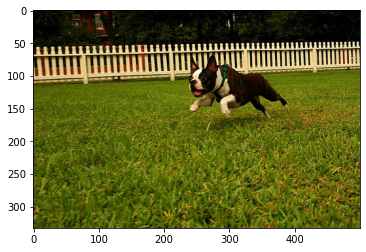

In [159]:
image_path = "flickr8k/Images/1009434119_febe49276a.jpg"
greedy_generated_caption(image_path, model, device)
beam_generated_captions(image_path, model, device)

Greedy generated caption
--------------------------------------------------
a man in a a rock climbing a cliff . . . . . .

Beam generated captions
--------------------------------------------------
a man is climbing a rock climbing . a cliff . . . . . . .
a man is climbing a rock climbing a cliff . . . . . . . .
a man is climbing a rock climbing . a cliff . a . . . . .
a man is climbing a rock climbing a cliff . . . . . . . ''
a man is climbing a rock climbing . a cliff . . . . . . ''


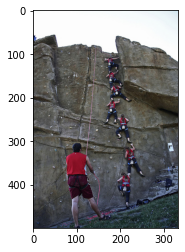

In [160]:
image_path = "flickr8k/Images/1016887272_03199f49c4.jpg"
greedy_generated_caption(image_path, model, device)
beam_generated_captions(image_path, model, device)

Greedy generated caption
--------------------------------------------------
a black dog is in the water . a red frisbee in its mouth .

Beam generated captions
--------------------------------------------------
a black dog is running through the water . a stick in its mouth . water .
a black dog is running through the water . a stick in its mouth . . .
a black dog is running through the water . a stick in its mouth . '' .
a black dog is running through the water . a stick in its mouth . . water
a black dog is running through the water . a stick in its mouth . . ''


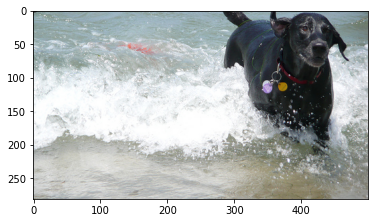

In [161]:
image_path = "flickr8k/Images/1022975728_75515238d8.jpg"
greedy_generated_caption(image_path, model, device)
beam_generated_captions(image_path, model, device)

Greedy generated caption
--------------------------------------------------
a young boy wearing a red shirt and a baseball . . a . . . . .

Beam generated captions
--------------------------------------------------
a young boy wearing a baseball cap is running through a field . . . . . . . .
a young boy wearing a baseball cap is running in a field . . . . . . . .
a young boy wearing a baseball cap is running through a field . . . . . . . ''
a young boy wearing a baseball cap is running in a field . . . . . . . ''
a young boy wearing a baseball cap is running in the air . a baseball . . . . .


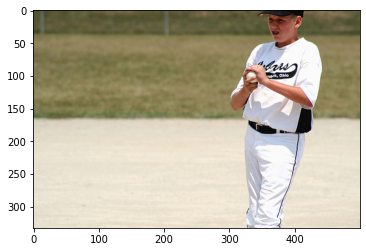

In [192]:
image_path = "flickr8k/Images/1285067106_2adc307240.jpg"
greedy_generated_caption(image_path, model, device)
beam_generated_captions(image_path, model, device)